# Hito 2 — Pipeline prototipo: Predicción de PM2.5 (t+1)

**Resumen:** Este notebook contiene un pipeline prototipo para predecir la concentración horaria de PM2.5 a horizonte t+1 (1 hora) utilizando los archivos consolidados en la carpeta `Datos`. Está pensado como una plantilla reproducible y ampliable para experimentar con estaciones individuales o modelos globales.

**Contenido del flujo:**
- Selección automática de la estación candidata (la que tiene más registros numéricos en `MP 2.5.csv`).
- Lectura robusta de los CSV de contaminación y detección automática de columnas `fecha`/`hora`/valor aunque los encabezados varíen.
- Conversión a `DatetimeIndex` y resampling horario (media por hora) para regularizar la serie temporal.
- Ingeniería de características: lags (1..24), medias móviles (3,6,12,24), y codificaciones cíclicas de hora y día de la semana.
- Generación de objetivos `target_t1`, `target_t6` y `target_t24` (en este pipeline nos enfocamos en `t+1`).
- Baseline de persistencia (usar `lag_1`), y entrenamiento de dos modelos: `Ridge` (lineal) y `RandomForestRegressor` (árbol).
- Evaluación con métricas: MAE, RMSE y R². Guardado de modelos con `joblib`.

**Objetivos del notebook:**
1. Proveer una implementación reproducible y fácil de entender para empezar a modelar PM2.5 por estación.
2. Servir como base para comparar modelos, experimentar con ventanas de lags, horizontes múltiples y validación temporal.

**Supuestos y advertencias:**
- Los CSV de entrada pueden tener encabezados con nombres variados; el código intenta detectarlos automáticamente, pero en casos extremos puede requerir ajuste manual.
- Se utiliza resampling horario por la heterogeneidad de resoluciones; esto puede ocultar información si la estación tiene datos finos (minutales).
- El particionado es cronológico (no aleatorio) para evitar fuga temporal. Para búsqueda de hiperparámetros se recomienda `TimeSeriesSplit`.

**Requisitos (entorno usado):**
- Python 3.8+ (el notebook se probó con el `venv_mindat` del workspace).
- Paquetes principales: `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `joblib`, (opcional: `lightgbm`, `xgboost`).

**Ejecución rápida (desde terminal en la raíz del repo):**
```powershell
.env_mindatcriptsython.exe -m nbconvert --to notebook --execute hito_2.ipynb --inplace
# o usar el script que creé para ejecución no interactiva:
.env_mindatcriptsython.exe scripts







**Notas finales:** Ajusta el parámetro de selección de estación o la ruta `base_dir` si tus archivos se encuentran en otra ubicación local.- Métricas impresas en consola y gráficos embebidos si se ejecuta el notebook interactivo.- Modelos serializados dentro de la carpeta `models/` (ej. `ridge_<station>_t1.joblib`, `rf_<station>_t1.joblib`, `scaler_...`).**Salida esperada:**```un_hito2_pipeline.py

In [27]:
# Imports y configuraciones básicas
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Ruta base hacia la carpeta 'Datos' (ajuste si corresponde)
base_dir = r'c:\Users\busta\Escritorio\mineria_datos_CC5205\Datos'
print('Base dir:', base_dir)

Base dir: c:\Users\busta\Escritorio\mineria_datos_CC5205\Datos


In [28]:
# Buscar la estación con más registros validados de MP 2.5
stations = []
for estacion in os.listdir(base_dir):
    cont_path = os.path.join(base_dir, estacion, 'Contaminacion', 'MP 2.5.csv')
    if os.path.isfile(cont_path):
        try:
            df_tmp = pd.read_csv(cont_path, sep=';', skiprows=1, usecols=[0,1,2], names=['fecha','hora','concentracion_de_MP_2_5'], dtype=str, low_memory=False)
            df_tmp['concentracion_de_MP_2_5'] = pd.to_numeric(df_tmp['concentracion_de_MP_2_5'].str.replace(',', '.'), errors='coerce')
            n_valid = int(df_tmp['concentracion_de_MP_2_5'].notna().sum())
            stations.append((estacion, n_valid))
        except Exception as e:
            # ignorar estaciones con formatos inesperados
            pass
# Ordenar y mostrar top 10
stations_sorted = sorted(stations, key=lambda x: x[1], reverse=True)
stations_sorted[:10]

# Seleccionar la mejor estación automáticamente (si existe)
if len(stations_sorted) == 0:
    raise FileNotFoundError('No se encontró ningún archivo MP 2.5 en la carpeta Datos; revise la ruta y nombres de archivo')
best_station, best_count = stations_sorted[0]
print(f'Mejor estación (más registros validados): {best_station} — {best_count} registros')

Mejor estación (más registros validados): Las Condes — 218687 registros


In [29]:
# Cargar la serie horaria de la estación seleccionada
cont_path = os.path.join(base_dir, best_station, 'Contaminacion', 'MP 2.5.csv')
df_raw = pd.read_csv(cont_path, sep=';', low_memory=False, dtype=str, header=0)
# Detectar columnas de fecha/hora y la columna numérica de valor automáticamente (caso-insensible)
cols = df_raw.columns.tolist()
print('Columnas encontradas (primeras 10):', cols[:10])
date_col = None
hour_col = None
for c in df_raw.columns:
    lc = c.lower()
    if 'fecha' in lc or 'date' in lc or 'yy' in lc:
        date_col = c
    if 'hora' in lc or 'time' in lc or 'hh' in lc:
        hour_col = c
# fallback: usar primeras columnas si no se detectan
if date_col is None:
    date_col = df_raw.columns[0]
if hour_col is None and len(df_raw.columns) > 1:
    hour_col = df_raw.columns[1]
# Encontrar la columna con más valores numéricos (excluyendo fecha/hora)
max_numeric = 0
value_col = None
for c in df_raw.columns:
    if c in (date_col, hour_col):
        continue
    s = df_raw[c].astype(str).str.replace(',', '.', regex=False)
    n = pd.to_numeric(s, errors='coerce').notna().sum()
    if n > max_numeric:
        max_numeric = n
        value_col = c
if value_col is None:
    raise ValueError('No se pudo identificar columna numérica de PM2.5 en el archivo')
# Normalizar nombres a 'fecha','hora','concentracion_de_MP_2_5'
df = df_raw.rename(columns={date_col: 'fecha', hour_col: 'hora', value_col: 'concentracion_de_MP_2_5'})

# Convertir a número y crear datetime robustamente
df['concentracion_de_MP_2_5'] = pd.to_numeric(df['concentracion_de_MP_2_5'].astype(str).str.replace(',', '.'), errors='coerce')
# Normalizar fecha/hora como strings y crear campo datetime
df['fecha'] = df['fecha'].astype(str).str.zfill(6)
df['hora'] = df['hora'].astype(str).str.zfill(4)
# Probar patrón YYMMDD HHMM (como en el notebook original). Si falla, caerá a to_datetime con infer.
df['datetime'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'], format='%y%m%d %H%M', errors='coerce')
# Fallback: inferir donde haya NaT
mask_nat = df['datetime'].isna()
if mask_nat.any():
    df.loc[mask_nat, 'datetime'] = pd.to_datetime(df.loc[mask_nat, 'fecha'] + ' ' + df.loc[mask_nat, 'hora'], errors='coerce', dayfirst=False, infer_datetime_format=True)
# Filtrar filas con datetime válido y valores numéricos
df = df.dropna(subset=['datetime'])
df = df.sort_values('datetime')
# Resample a horario (media) para garantizar regularidad horaria
df = df.set_index('datetime')
series_hour = df['concentracion_de_MP_2_5'].resample('H').mean()
print('Rango temporal de la serie:', series_hour.index.min(), '->', series_hour.index.max())
print('Registros horarios con valor numérico:', series_hour.notna().sum())
# Mostrar primeros valores
series_hour.head()

Columnas encontradas (primeras 10): ['FECHA (YYMMDD)', 'HORA (HHMM)', 'Registros validados', 'Registros preliminares', 'Registros no validados', 'Unnamed: 5']
Rango temporal de la serie: 2000-01-01 01:00:00 -> 2025-09-30 23:00:00
Registros horarios con valor numérico: 218687
Rango temporal de la serie: 2000-01-01 01:00:00 -> 2025-09-30 23:00:00
Registros horarios con valor numérico: 218687


C:\Users\busta\AppData\Local\Temp\ipykernel_26380\2359512637.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series_hour = df['concentracion_de_MP_2_5'].resample('H').mean()


datetime
2000-01-01 01:00:00    29.0
2000-01-01 02:00:00    27.0
2000-01-01 03:00:00    21.0
2000-01-01 04:00:00    19.0
2000-01-01 05:00:00    19.0
Freq: h, Name: concentracion_de_MP_2_5, dtype: float64

In [30]:
# Si la serie seleccionada no tiene valores, intentar con la siguiente estación disponible
if series_hour.notna().sum() == 0:
    print('Estación seleccionada no tiene datos útiles. Buscando alternativa...')
    found = False
    for estacion, _ in stations_sorted[1:]:
        cont_path_alt = os.path.join(base_dir, estacion, 'Contaminacion', 'MP 2.5.csv')
        if not os.path.isfile(cont_path_alt):
            continue
        try:
            df_alt = pd.read_csv(cont_path_alt, sep=';', skiprows=1, names=['fecha','hora','concentracion_de_MP_2_5','a','b'], dtype=str, low_memory=False)
            df_alt['concentracion_de_MP_2_5'] = pd.to_numeric(df_alt['concentracion_de_MP_2_5'].astype(str).str.replace(',', '.'), errors='coerce')
            df_alt['fecha'] = df_alt['fecha'].astype(str).str.zfill(6)
            df_alt['hora'] = df_alt['hora'].astype(str).str.zfill(4)
            df_alt['datetime'] = pd.to_datetime(df_alt['fecha'] + ' ' + df_alt['hora'], format='%y%m%d %H%M', errors='coerce')
            df_alt = df_alt.dropna(subset=['datetime'])
            df_alt = df_alt.set_index('datetime')
            series_alt = df_alt['concentracion_de_MP_2_5'].resample('H').mean()
            if series_alt.notna().sum() > 0:
                series_hour = series_alt
                best_station = estacion
                found = True
                print(f'Seleccionada estación alternativa: {best_station} con {series_hour.notna().sum()} mediciones horarias')
                break
        except Exception:
            continue
    if not found:
        raise ValueError('No se encontraron estaciones con datos útiles en la carpeta Datos')

# Construir dataframe de features: lags y medias móviles
data = pd.DataFrame({'pm25': series_hour})
# Crear lags 1..24
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['pm25'].shift(lag)
# Medias móviles
for w in (3, 6, 12, 24):
    data[f'roll_mean_{w}'] = data['pm25'].rolling(window=w, min_periods=1).mean()
# Variables temporales (hora del día y día de la semana con codificación sin/cos)
data = data.reset_index()
data['hour'] = data['datetime'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['weekday'] = data['datetime'].dt.weekday
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)
data = data.set_index('datetime')
data.head()

,pm25,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,roll_mean_3,roll_mean_6,roll_mean_12,roll_mean_24,hour,hour_sin,hour_cos,weekday,weekday_sin,weekday_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 01:00:00,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.000000,29.000000,29.000000,29.000000,1,0.258819,0.965926,5,-0.974928,-0.222521
2000-01-01 02:00:00,27.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.000000,28.000000,28.000000,28.000000,2,0.500000,0.866025,5,-0.974928,-0.222521
2000-01-01 03:00:00,21.0,27.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.666667,25.666667,25.666667,25.666667,3,0.707107,0.707107,5,-0.974928,-0.222521
2000-01-01 04:00:00,19.0,21.0,27.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,22.333333,24.000000,24.000000,24.000000,4,0.866025,0.500000,5,-0.974928,-0.222521
2000-01-01 05:00:00,19.0,19.0,21.0,27.0,29.0,NaN,NaN,NaN,NaN,NaN,...,19.666667,23.000000,23.000000,23.000000,5,0.965926,0.258819,5,-0.974928,-0.222521


In [31]:
# Crear objetivos: t+1, t+6, t+24 (aquí nos enfocamos en t+1)
data['target_t1'] = data['pm25'].shift(-1)
data['target_t6'] = data['pm25'].shift(-6)
data['target_t24'] = data['pm25'].shift(-24)
# Seleccionar features y eliminar filas con NA resultantes
feature_cols = [c for c in data.columns if c.startswith('lag_') or c.startswith('roll_mean_') or c.endswith('_sin') or c.endswith('_cos')]
target_col = 'target_t1'
df_model = data.dropna(subset=feature_cols + [target_col]).copy()
print('Muestras disponibles para modelado (t+1):', len(df_model))
df_model.head()

Muestras disponibles para modelado (t+1): 206379


,pm25,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,roll_mean_24,hour,hour_sin,hour_cos,weekday,weekday_sin,weekday_cos,target_t1,target_t6,target_t24
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-02 01:00:00,11.0,10.0,10.0,13.0,13.0,12.0,12.0,16.0,17.0,19.0,...,19.750000,1,0.258819,0.965926,6,-0.781831,0.62349,13.0,21.0,12.0
2000-01-02 02:00:00,13.0,11.0,10.0,10.0,13.0,13.0,12.0,12.0,16.0,17.0,...,19.166667,2,0.500000,0.866025,6,-0.781831,0.62349,8.0,23.0,9.0
2000-01-02 03:00:00,8.0,13.0,11.0,10.0,10.0,13.0,13.0,12.0,12.0,16.0,...,18.625000,3,0.707107,0.707107,6,-0.781831,0.62349,10.0,23.0,10.0
2000-01-02 04:00:00,10.0,8.0,13.0,11.0,10.0,10.0,13.0,13.0,12.0,12.0,...,18.250000,4,0.866025,0.500000,6,-0.781831,0.62349,13.0,27.0,10.0
2000-01-02 05:00:00,13.0,10.0,8.0,13.0,11.0,10.0,10.0,13.0,13.0,12.0,...,18.000000,5,0.965926,0.258819,6,-0.781831,0.62349,17.0,26.0,12.0


In [32]:
# Partición temporal: 70% train, 15% val, 15% test (cronológica)
n = len(df_model)
# Si hay muy pocas muestras, avisar al usuario para escoger otra estación o recolectar más datos
if n < 10:
    raise ValueError(f'Pocas muestras ({n}) para modelar; seleccione otra estación o aumente la ventana temporal')
i1 = max(int(0.7 * n), 1)
i2 = max(int(0.85 * n), i1 + 1)
# Asegurar que i2 quede dentro del rango
if i2 >= n:
    i2 = n - 1
train = df_model.iloc[:i1]
val = df_model.iloc[i1:i2]
test = df_model.iloc[i2:]
# Si alguna partición queda vacía, usar una partición fallback (60/20/20) garantizando al menos 1 muestra por bloque
if len(train) == 0 or len(val) == 0 or len(test) == 0:
    i1 = max(int(0.6 * n), 1)
    i2 = min(n - 1, i1 + max(int(0.2 * n), 1))
    train = df_model.iloc[:i1]
    val = df_model.iloc[i1:i2]
    test = df_model.iloc[i2:]
X_train = train[feature_cols]
y_train = train[target_col]
X_val = val[feature_cols]
y_val = val[target_col]
X_test = test[feature_cols]
y_test = test[target_col]
print('Train / Val / Test sizes:', X_train.shape[0], X_val.shape[0], X_test.shape[0])

Train / Val / Test sizes: 144465 30957 30957


In [33]:
# Baseline: persistencia (usar lag_1 como predicción para t+1)
y_pred_persist = X_test['lag_1']
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    # some sklearn versions don't support squared=False, compute RMSE explicitly
    rmse = (mean_squared_error(y_true, y_pred)) ** 0.5
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2
mae_p, rmse_p, r2_p = metrics(y_test, y_pred_persist)
print('Baseline (persistencia) — t+1')
print(f'MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, R2: {r2_p:.3f}')

Baseline (persistencia) — t+1
MAE: 4.955, RMSE: 7.528, R2: 0.688


In [34]:
# Modelo 1: Ridge (escala necesaria)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
ridge = Ridge(alpha=1.0, random_state=0)
ridge.fit(X_train_s, y_train)
y_pred_ridge = ridge.predict(X_test_s)
mae_r, rmse_r, r2_r = metrics(y_test, y_pred_ridge)
print('Ridge — t+1')
print(f'MAE: {mae_r:.3f}, RMSE: {rmse_r:.3f}, R2: {r2_r:.3f}')

Ridge — t+1
MAE: 3.648, RMSE: 5.234, R2: 0.849

MAE: 3.648, RMSE: 5.234, R2: 0.849


In [35]:
# Modelo 2: RandomForestRegressor (no escala obligatoria)
rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mae_rf, rmse_rf, r2_rf = metrics(y_test, y_pred_rf)
print('RandomForest — t+1')
print(f'MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}')

# Comparar con baseline
print('\nComparación (lower MAE mejor):')
print(f'Persistencia MAE: {mae_p:.3f} — Ridge MAE: {mae_r:.3f} — RF MAE: {mae_rf:.3f}')

RandomForest — t+1
MAE: 3.712, RMSE: 5.426, R2: 0.838

Comparación (lower MAE mejor):
Persistencia MAE: 4.955 — Ridge MAE: 3.648 — RF MAE: 3.712


In [36]:
# ----- Entrenamiento y evaluación para t+6 (6 horas) -----
target_col = 'target_t6'
df_model6 = data.dropna(subset=feature_cols + [target_col]).copy()
n6 = len(df_model6)
print('Muestras disponibles para modelado (t+6):', n6)
if n6 < 10:
    print('Pocas muestras para t+6. Salta el entrenamiento de t+6.')
else:
    # partición cronológica (70/15/15 fallback)
    i1 = max(int(0.7 * n6), 1)
    i2 = max(int(0.85 * n6), i1 + 1)
    if i2 >= n6:
        i2 = n6 - 1
    train6 = df_model6.iloc[:i1]
    val6 = df_model6.iloc[i1:i2]
    test6 = df_model6.iloc[i2:]
    if len(train6) == 0 or len(val6) == 0 or len(test6) == 0:
        i1 = max(int(0.6 * n6), 1)
        i2 = min(n6 - 1, i1 + max(int(0.2 * n6), 1))
        train6 = df_model6.iloc[:i1]
        val6 = df_model6.iloc[i1:i2]
        test6 = df_model6.iloc[i2:]
    X_train6 = train6[feature_cols]
    y_train6 = train6[target_col]
    X_val6 = val6[feature_cols]
    y_val6 = val6[target_col]
    X_test6 = test6[feature_cols]
    y_test6 = test6[target_col]
    print('Train / Val / Test sizes (t+6):', X_train6.shape[0], X_val6.shape[0], X_test6.shape[0])
    # Baseline: persistencia con lag_6
    if 'lag_6' in X_test6.columns:
        y_pred_persist6 = X_test6['lag_6']
    else:
        y_pred_persist6 = X_test6['lag_1']  # fallback
    mae_p6, rmse_p6, r2_p6 = metrics(y_test6, y_pred_persist6)
    print('Baseline (persistencia) — t+6')
    print(f'MAE: {mae_p6:.3f}, RMSE: {rmse_p6:.3f}, R2: {r2_p6:.3f}')
    # Ridge (escalado)
    scaler6 = StandardScaler()
    X_train6_s = scaler6.fit_transform(X_train6)
    X_val6_s = scaler6.transform(X_val6)
    X_test6_s = scaler6.transform(X_test6)
    ridge6 = Ridge(alpha=1.0, random_state=0)
    ridge6.fit(X_train6_s, y_train6)
    y_pred_ridge6 = ridge6.predict(X_test6_s)
    mae_r6, rmse_r6, r2_r6 = metrics(y_test6, y_pred_ridge6)
    print('Ridge — t+6')
    print(f'MAE: {mae_r6:.3f}, RMSE: {rmse_r6:.3f}, R2: {r2_r6:.3f}')
    # RandomForest
    rf6 = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
    rf6.fit(X_train6, y_train6)
    y_pred_rf6 = rf6.predict(X_test6)
    mae_rf6, rmse_rf6, r2_rf6 = metrics(y_test6, y_pred_rf6)
    print('RandomForest — t+6')
    print(f'MAE: {mae_rf6:.3f}, RMSE: {rmse_rf6:.3f}, R2: {r2_rf6:.3f}')
    # Guardar modelos t+6
    out_dir = Path('models')
    out_dir.mkdir(exist_ok=True)
    joblib.dump(ridge6, out_dir / f'ridge_{best_station}_t6.joblib')
    joblib.dump(rf6, out_dir / f'rf_{best_station}_t6.joblib')
    joblib.dump(scaler6, out_dir / f'scaler_{best_station}_t6.joblib')
    print('Modelos t+6 guardados en:', out_dir.resolve())

Muestras disponibles para modelado (t+6): 205686
Train / Val / Test sizes (t+6): 143980 30853 30853
Baseline (persistencia) — t+6
MAE: 10.051, RMSE: 15.044, R2: -0.247
Ridge — t+6Ridge — t+6
MAE: 6.656, RMSE: 9.378, R2: 0.515

MAE: 6.656, RMSE: 9.378, R2: 0.515
RandomForest — t+6
MAE: 6.281, RMSE: 9.183, R2: 0.535
RandomForest — t+6
MAE: 6.281, RMSE: 9.183, R2: 0.535
Modelos t+6 guardados en: C:\Users\busta\Escritorio\mineria_datos_CC5205\models
Modelos t+6 guardados en: C:\Users\busta\Escritorio\mineria_datos_CC5205\models


In [37]:
# ----- Entrenamiento y evaluación para t+24 (24 horas) -----
target_col = 'target_t24'
df_model24 = data.dropna(subset=feature_cols + [target_col]).copy()
n24 = len(df_model24)
print('Muestras disponibles para modelado (t+24):', n24)
if n24 < 10:
    print('Pocas muestras para t+24. Salta el entrenamiento de t+24.')
else:
    i1 = max(int(0.7 * n24), 1)
    i2 = max(int(0.85 * n24), i1 + 1)
    if i2 >= n24:
        i2 = n24 - 1
    train24 = df_model24.iloc[:i1]
    val24 = df_model24.iloc[i1:i2]
    test24 = df_model24.iloc[i2:]
    if len(train24) == 0 or len(val24) == 0 or len(test24) == 0:
        i1 = max(int(0.6 * n24), 1)
        i2 = min(n24 - 1, i1 + max(int(0.2 * n24), 1))
        train24 = df_model24.iloc[:i1]
        val24 = df_model24.iloc[i1:i2]
        test24 = df_model24.iloc[i2:]
    X_train24 = train24[feature_cols]
    y_train24 = train24[target_col]
    X_val24 = val24[feature_cols]
    y_val24 = val24[target_col]
    X_test24 = test24[feature_cols]
    y_test24 = test24[target_col]
    print('Train / Val / Test sizes (t+24):', X_train24.shape[0], X_val24.shape[0], X_test24.shape[0])
    # Baseline: persistencia con lag_24
    if 'lag_24' in X_test24.columns:
        y_pred_persist24 = X_test24['lag_24']
    else:
        y_pred_persist24 = X_test24['lag_1']  # fallback
    mae_p24, rmse_p24, r2_p24 = metrics(y_test24, y_pred_persist24)
    print('Baseline (persistencia) — t+24')
    print(f'MAE: {mae_p24:.3f}, RMSE: {rmse_p24:.3f}, R2: {r2_p24:.3f}')
    # Ridge (escalado)
    scaler24 = StandardScaler()
    X_train24_s = scaler24.fit_transform(X_train24)
    X_val24_s = scaler24.transform(X_val24)
    X_test24_s = scaler24.transform(X_test24)
    ridge24 = Ridge(alpha=1.0, random_state=0)
    ridge24.fit(X_train24_s, y_train24)
    y_pred_ridge24 = ridge24.predict(X_test24_s)
    mae_r24, rmse_r24, r2_r24 = metrics(y_test24, y_pred_ridge24)
    print('Ridge — t+24')
    print(f'MAE: {mae_r24:.3f}, RMSE: {rmse_r24:.3f}, R2: {r2_r24:.3f}')
    # RandomForest
    rf24 = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
    rf24.fit(X_train24, y_train24)
    y_pred_rf24 = rf24.predict(X_test24)
    mae_rf24, rmse_rf24, r2_rf24 = metrics(y_test24, y_pred_rf24)
    print('RandomForest — t+24')
    print(f'MAE: {mae_rf24:.3f}, RMSE: {rmse_rf24:.3f}, R2: {r2_rf24:.3f}')
    # Guardar modelos t+24
    out_dir = Path('models')
    out_dir.mkdir(exist_ok=True)
    joblib.dump(ridge24, out_dir / f'ridge_{best_station}_t24.joblib')
    joblib.dump(rf24, out_dir / f'rf_{best_station}_t24.joblib')
    joblib.dump(scaler24, out_dir / f'scaler_{best_station}_t24.joblib')
    print('Modelos t+24 guardados en:', out_dir.resolve())

Muestras disponibles para modelado (t+24): 204586
Train / Val / Test sizes (t+24): 143210 30688 30688
Baseline (persistencia) — t+24
MAE: 9.429, RMSE: 14.037, R2: -0.082
 204586
Train / Val / Test sizes (t+24): 143210 30688 30688
Baseline (persistencia) — t+24
MAE: 9.429, RMSE: 14.037, R2: -0.082
Ridge — t+24
MAE: 8.031, RMSE: 10.842, R2: 0.354
Ridge — t+24
MAE: 8.031, RMSE: 10.842, R2: 0.354
RandomForest — t+24
MAE: 7.484, RMSE: 10.606, R2: 0.382
RandomForest — t+24
MAE: 7.484, RMSE: 10.606, R2: 0.382
Modelos t+24 guardados en: C:\Users\busta\Escritorio\mineria_datos_CC5205\models
Modelos t+24 guardados en: C:\Users\busta\Escritorio\mineria_datos_CC5205\models


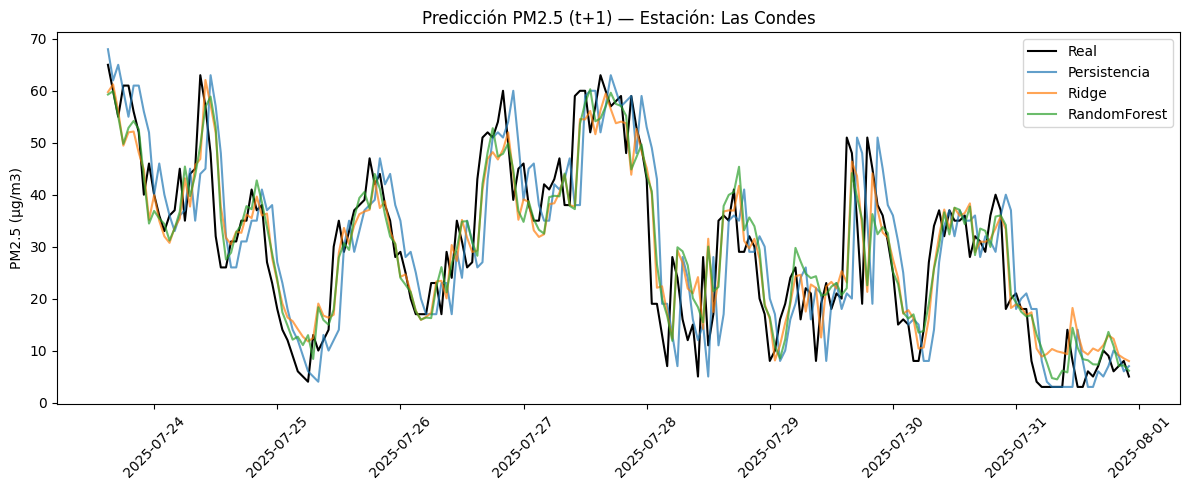

In [38]:
# Graficar predicciones vs real (últimas N muestras del test)
N = 200
idx = y_test.index[-N:] if len(y_test) > N else y_test.index
plt.figure(figsize=(12,5))
plt.plot(idx, y_test.loc[idx], label='Real', color='black')
plt.plot(idx, y_pred_persist[-len(idx):], label='Persistencia', alpha=0.7)
plt.plot(idx, y_pred_ridge[-len(idx):], label='Ridge', alpha=0.7)
plt.plot(idx, y_pred_rf[-len(idx):], label='RandomForest', alpha=0.7)
plt.legend()
plt.title(f'Predicción PM2.5 (t+1) — Estación: {best_station}')
plt.ylabel('PM2.5 (µg/m3)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Guardar modelos y scaler (opcional)
out_dir = Path('models')
out_dir.mkdir(exist_ok=True)
joblib.dump(ridge, out_dir / f'ridge_{best_station}_t1.joblib')
joblib.dump(rf, out_dir / f'rf_{best_station}_t1.joblib')
joblib.dump(scaler, out_dir / f'scaler_{best_station}_t1.joblib')
print('Modelos guardados en:', out_dir.resolve())

Modelos guardados en: C:\Users\busta\Escritorio\mineria_datos_CC5205\models


**Resultados del último entrenamiento**

A continuación se muestra un resumen con las métricas calculadas en las celdas previas (baseline, Ridge y RandomForest) y se guarda un CSV resumen en la carpeta `models/`. Si se ejecuta este bloque y faltan variables, ejecute primero las celdas de entrenamiento.

In [40]:
# Resumen de métricas del último entrenamiento
try:
    results = {
        'station': best_station,
        'target': target_col,
        'n_samples': int(len(df_model)) if 'df_model' in globals() else None,
        'baseline_mae': float(mae_p), 'baseline_rmse': float(rmse_p), 'baseline_r2': float(r2_p),
        'ridge_mae': float(mae_r), 'ridge_rmse': float(rmse_r), 'ridge_r2': float(r2_r),
        'rf_mae': float(mae_rf), 'rf_rmse': float(rmse_rf), 'rf_r2': float(r2_rf)
    }
except NameError:
    print('Algunas variables de métricas no existen en el entorno. Ejecute las celdas de entrenamiento primero.')
else:
    import pandas as _pd
    df_res = _pd.DataFrame([results])
    try:
        display(df_res.T.rename(columns={0:'value'}))
    except Exception:
        print(df_res.T)
    # Guardar resumen en CSV dentro de models/
    out_dir = Path('models')
    out_dir.mkdir(exist_ok=True)
    csv_path = out_dir / f'results_summary_{best_station}_{target_col}.csv'
    df_res.to_csv(csv_path, index=False)
    print('Resumen guardado en', csv_path.resolve())

,value
station,Las Condes
target,target_t24
n_samples,206379
baseline_mae,4.955293
baseline_rmse,7.527514
baseline_r2,0.688456
ridge_mae,3.647687
ridge_rmse,5.233612
ridge_r2,0.849402
rf_mae,3.711987


Resumen guardado en C:\Users\busta\Escritorio\mineria_datos_CC5205\models\results_summary_Las Condes_target_t24.csv


## Siguientes pasos recomendados:
- Verificar la calidad y continuidad de la serie seleccionada; ajustar la imputación de faltantes si corresponde.
- Repetir el entrenamiento para `t+6` y `t+24` (usar `target_t6` y `target_t24`).
- Probar `TimeSeriesSplit` para validación temporal y búsqueda de hiperparámetros (GridSearchCV con CV temporal).
- Experimentar con modelos basados en boosting (LightGBM/XGBoost) y modelos secuenciales (LSTM) si se busca mejorar rendimiento en horizontes largos.
- Extender a modelos multiestación o modelos globales con `station_id` como feature.

## Gráficos de precisión por horizonte

Las siguientes figuras muestran la serie real frente a las predicciones (baseline, Ridge, RandomForest) para cada horizonte entrenado. Además se genera un gráfico resumen con las métricas (MAE y RMSE) por modelo y horizonte. Si alguna horizon no fue entrenada, será omitida automáticamente.

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as _np
import pandas as _pd
out_dir = Path('models')
out_dir.mkdir(exist_ok=True)
# Preparar lista de horizontes disponibles
horizons = []
# t+1 variables esperadas: y_test, y_pred_persist, y_pred_ridge, y_pred_rf
if 'y_test' in globals():
    try:
        y_pred_persist_s = _pd.Series(y_pred_persist, index=y_test.index) if not hasattr(y_pred_persist, 'index') else y_pred_persist
    except Exception:
        y_pred_persist_s = None
    try:
        y_pred_ridge_s = _pd.Series(y_pred_ridge, index=y_test.index)
    except Exception:
        y_pred_ridge_s = None
    try:
        y_pred_rf_s = _pd.Series(y_pred_rf, index=y_test.index)
    except Exception:
        y_pred_rf_s = None
    horizons.append(('t+1', y_test, y_pred_persist_s, y_pred_ridge_s, y_pred_rf_s, mae_p, rmse_p, r2_p, mae_r, rmse_r, r2_r, mae_rf, rmse_rf, r2_rf))
# t+6
if 'y_test6' in globals():
    try:
        yp_p6 = _pd.Series(y_pred_persist6, index=y_test6.index) if not hasattr(y_pred_persist6, 'index') else y_pred_persist6
    except Exception:
        yp_p6 = None
    try:
        yp_r6 = _pd.Series(y_pred_ridge6, index=y_test6.index)
    except Exception:
        yp_r6 = None
    try:
        yp_rf6 = _pd.Series(y_pred_rf6, index=y_test6.index)
    except Exception:
        yp_rf6 = None
    horizons.append(('t+6', y_test6, yp_p6, yp_r6, yp_rf6, mae_p6, rmse_p6, r2_p6, mae_r6, rmse_r6, r2_r6, mae_rf6, rmse_rf6, r2_rf6))
# t+24
if 'y_test24' in globals():
    try:
        yp_p24 = _pd.Series(y_pred_persist24, index=y_test24.index) if not hasattr(y_pred_persist24, 'index') else y_pred_persist24
    except Exception:
        yp_p24 = None
    try:
        yp_r24 = _pd.Series(y_pred_ridge24, index=y_test24.index)
    except Exception:
        yp_r24 = None
    try:
        yp_rf24 = _pd.Series(y_pred_rf24, index=y_test24.index)
    except Exception:
        yp_rf24 = None
    horizons.append(('t+24', y_test24, yp_p24, yp_r24, yp_rf24, mae_p24, rmse_p24, r2_p24, mae_r24, rmse_r24, r2_r24, mae_rf24, rmse_rf24, r2_rf24))
# Dibujar por cada horizonte disponible
for h in horizons:
    name = h[0]
    y_true = h[1]
    y_persist = h[2]
    y_ridge = h[3]
    y_rf = h[4]
    # tomar últimas N muestras para visibilidad
    N = 300
    idx = y_true.index[-N:] if len(y_true) > N else y_true.index
    plt.figure(figsize=(12,4))
    plt.plot(idx, y_true.loc[idx], label='Real', color='black')
    if y_persist is not None:
        try:
            plt.plot(idx, y_persist.loc[idx], label='Persistencia', alpha=0.8)
        except Exception:
            plt.plot(idx, y_persist[-len(idx):], label='Persistencia', alpha=0.8)
    if y_ridge is not None:
        try:
            plt.plot(idx, y_ridge.loc[idx], label='Ridge', alpha=0.8)
        except Exception:
            plt.plot(idx, y_ridge[-len(idx):], label='Ridge', alpha=0.8)
    if y_rf is not None:
        try:
            plt.plot(idx, y_rf.loc[idx], label='RandomForest', alpha=0.8)
        except Exception:
            plt.plot(idx, y_rf[-len(idx):], label='RandomForest', alpha=0.8)
    plt.legend()
    plt.title(f'Predicción PM2.5 ({name}) — Estación: {best_station}')
    plt.ylabel('PM2.5 (µg/m3)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    fig_path = out_dir / f'predictions_{best_station}_{name}.png'
    plt.savefig(fig_path, dpi=150)
    print('Figura guardada en', fig_path.resolve())
    plt.show()
# Gráfico resumen de métricas (MAE y RMSE) por horizonte y modelo
rows = []
for h in horizons:
    name = h[0]
    rows.append({'horizon': name, 'model': 'baseline', 'mae': float(h[5]), 'rmse': float(h[6])})
    rows.append({'horizon': name, 'model': 'ridge', 'mae': float(h[8]), 'rmse': float(h[9])})
    rows.append({'horizon': name, 'model': 'rf', 'mae': float(h[11]), 'rmse': float(h[12])})
if len(rows) > 0:
    df_metrics = _pd.DataFrame(rows)
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    import seaborn as sns
    sns.barplot(data=df_metrics, x='horizon', y='mae', hue='model', ax=axes[0])
    axes[0].set_title('MAE por horizonte y modelo')
    sns.barplot(data=df_metrics, x='horizon', y='rmse', hue='model', ax=axes[1])
    axes[1].set_title('RMSE por horizonte y modelo')
    plt.tight_layout()
    summary_path = out_dir / f'metrics_summary_{best_station}.png'
    fig.savefig(summary_path, dpi=150)
    print('Gráfico resumen guardado en', summary_path.resolve())
    plt.show()
else:
    print('No hay métricas disponibles para dibujar resumen.')